In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import tensorflow as tf
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')

# Giới thiệu về LSTM Model (ghi dùm)

In [7]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)


,raw_comment,normalize_comment,emoji_decode
0,form k đẹp lắm,form không đẹp lắm,
1,Áo Rộng thật sự\nGl nhanh\nChật lươ...,áo rộng thật sự nhanh chật lượng v...,
2,Màu túi hơi tối do với ảnh chụp,màu túi hơi tối do ảnh chụp,
3,Chất liệu vải k ổn lắm,chất liệu vải không ổn lắm,
4,"Mã ""màu đen"" hiện lên áo màu đen, còn ...",mã màu đen hiện lên áo màu đen còn mã...,
...,...,...,...
11359,"Khi bán combo ghi 3 đôi, nhưng nhận chỉ ...",bán combo ghi đôi nhưng nhận chỉ đôi ta...,
11360,"Áo đẹp, from chuẩn. Sẽ ủng hộ tiếp ạ !",áo đẹp from chuẩn sẽ ủng hộ tiếp,
11361,Đặt màu trắng kem thì giao màu xanh đen...,đặt màu trắng kem giao màu xanh đen giao...,expressionless
11362,Đồ chơi tí hon.\nShop nên dừng bán sp ...,đồ chơi tí hon nên dừng bán sản phẩ...,


,label
0,0
1,1
2,0
3,0
4,0
...,...
11359,0
11360,1
11361,0
11362,0


,raw_comment,normalize_comment,emoji_decode
0,Shop bán hàng kỉ quấn đầy đủ. Chất l...,bán hàng kỉ quấn đầy đủ chất lượn...,
1,"Đặt xl, áo ghi xl nhưng lại bé tí tẹo ...",đặt xl áo ghi xl nhưng bé tí tẹo ngang ...,
2,Kẹp rất rất đẹp săn được giá sale h...,kẹp rất rất đẹp săn được giá sale h...,
3,K nghĩ áo đẹp vậy đâu giao hàng nhanh k...,không nghĩ áo đẹp giao hàng nhanh không ...,
4,Hôm nay mới nhận đc nhưng nhìn qua thâ...,hôm nay mới nhận được nhưng nhìn qua...,
...,...,...,...
2837,Mình đặt 2 dây buộc tóc nhưng lại chi...,đặt dây buộc tóc nhưng chỉ nhận đưo...,star slightly_smiling_face slightly_smiling_fa...
2838,"Chất vải đẹp, có vẻ mát, giao hàng nha...",chất vải đẹp có vẻ mát giao hàng nhanh...,
2839,Dây nhìn tạm. K đẹp. Mắc sai dây mình ...,dây nhìn tạm không đẹp mắc sai dây pha...,
2840,Quần đẹp chất lượng ok nhưng chữ ru...,quần đẹp chất lượng ok nhưng chữ cu...,


,label
0,1
1,0
2,1
3,1
4,1
...,...
2837,0
2838,1
2839,0
2840,1


Xây dựng một Tokenizer dựa trên training data. Ta sẽ đại diện cho một comment là một vector 100 chiều. Vì như ở projec 2, ta phân tích được rằng một comment của ta có khoảng cao nhất là loanh quanh 80 từ. Ngoài ra, ta cũng cần padding dữ liệu bằng các con số 0 vào đầu mỗi comment khi số từ của comment đó không đủ 100 từ, lúc này Tokenizer thực hiện indexing cho các kí tự. Lúc này toàn bộ các comment của chúng ta sẽ có cùng một chiều dài vector là 100.

In [8]:
X_train_comments = Model.convertToNFX(X_train['normalize_comment'], 'NFC')
X_test_comments = Model.convertToNFX(X_test['normalize_comment'], 'NFC')

In [9]:
tokenizer = DeepModel.tokenize(X_train_comments)
token_train_cmts = tokenizer.texts_to_sequences(X_train_comments)
padded_train_cmts = DeepModel.padding(token_train_cmts)

Chúng ta sẽ sử dụng 10 neuron cho LSTM layer, dùng hàm softmax để tránh đạo hàm rơi vào vùng bão hòa và ta cũng cần giá trị xác suất để tiến hành hợp nhất với emoji sentiment model. Dropout ta chọn 20% để hạn chế overfitting.

In [10]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = padded_train_cmts.shape[1]
neurons = 10
dropout = 0.2

lstm_model = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)

In [11]:
lstm_model.summary()
plot_model(lstm_model, to_file="./images/LSTM_sentiment.png", show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          358500    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                4440      
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 362,962
Trainable params: 362,962
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [31]:
batch_size = 32
epochs = 10
save_path = "./models/LSTM_sentiment.h5"
DeepModel.fit(lstm_model, padded_train_cmts, y_train, batch_size, epochs, save_path) 

Epoch 1/10
320/320 [==============================] - 19s 58ms/step - loss: 0.0948 - accuracy: 0.9697 - val_loss: 0.4694 - val_accuracy: 0.8663
Epoch 2/10
320/320 [==============================] - 18s 57ms/step - loss: 0.0916 - accuracy: 0.9708 - val_loss: 0.4847 - val_accuracy: 0.8575
Epoch 3/10
320/320 [==============================] - 17s 53ms/step - loss: 0.0921 - accuracy: 0.9688 - val_loss: 0.5059 - val_accuracy: 0.8566
Epoch 4/10
320/320 [==============================] - 17s 52ms/step - loss: 0.0864 - accuracy: 0.9725 - val_loss: 0.5175 - val_accuracy: 0.8558
Epoch 5/10
320/320 [==============================] - 18s 56ms/step - loss: 0.0822 - accuracy: 0.9738 - val_loss: 0.5470 - val_accuracy: 0.8522
Epoch 6/10
320/320 [==============================] - 18s 57ms/step - loss: 0.0784 - accuracy: 0.9750 - val_loss: 0.5486 - val_accuracy: 0.8505
Epoch 7/10
320/320 [==============================] - 18s 56ms/step - loss: 0.0740 - accuracy: 0.9778 - val_loss: 0.5545 - val_accuracy:

In [13]:
!tensorboard --logdir ./tb_log_sentiment --port 6006

2021-10-28 21:25:23.164704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-28 21:25:23.164733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-28 21:25:30.162308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:25:30.163296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-28 21:25:30.163531: W tensorflow

![](./images/10.png)

> **Nhận xét**:
> * Đây là line chart trên accuracy và loss do TensorBoard vẽ ra, với màu xanh là của validation data và cam là training data.
> * Ta thấy kể từ sau epoch đầu tiên thì giữa validation và train bắt đầu có sự khác biệt, chứng tỏ model đang bị overfitting.

Tiếp theo, ta sẽ tokenizer cho test data để tiến hành đánh giá trên test data.

In [14]:
token_test_cmts = tokenizer.texts_to_sequences(X_test_comments)
padded_test_cmts = DeepModel.padding(token_test_cmts)

              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87      1410
    Positive       0.87      0.86      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.87      0.87      0.87      2842
weighted avg       0.87      0.87      0.87      2842



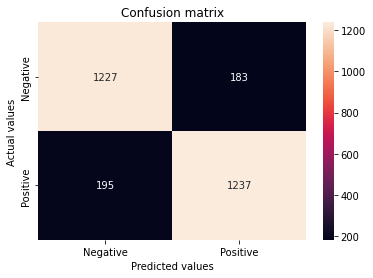

In [19]:
prediction = lstm_model.predict(padded_test_cmts)
inverted = np.argmax(prediction, axis=1)
Model.confusionMatrix(y_test, inverted)

Do ta có áp dụng checkpoint trong model để lưu lại các bộ tham số tốt nhất trong quá trình training, ta có thể lấy bộ tham số mà có validation loss thấp nhất để update trọng số cho model.

In [27]:
lstm_model_uw = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)
lstm_model_uw.load_weights("./models/LSTM_sentiment/weights/02-0.333198.h5")

              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      1410
    Positive       0.89      0.85      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.87      0.87      0.87      2842
weighted avg       0.87      0.87      0.87      2842



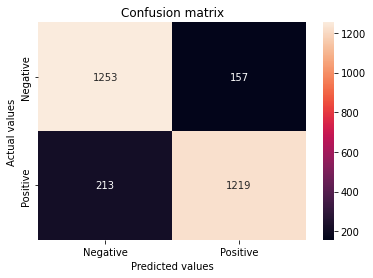

In [28]:
prediction = lstm_model_uw.predict(padded_test_cmts)
inverted = np.argmax(prediction, axis=1)
Model.confusionMatrix(y_test, inverted)

> **Nhận xét**:
> * So với các **Traditional machine learning** model mà ta đã đào tạo ở file `07.model.ipynb` - chúng có xu hướng dự đoán nhầm các mẫu thuộc nhóm **positive** sang **negative**, thì với Deep Learning điều này được khắc phục phần nào.
> * Tuy nhiên, nó lại bắt đầu nhầm từ các mẫu theo đúng là **negative** nhưng lại dự đoán sang **positive**.
> * Nhưng nhìn chung, ta thấy model LSTM dự đoán có sự cân bằng giữa các nhóm, accuracy hơn 85% trên dữ liệu dạng text như vậy là đáng mừng.

Ta sẽ thử tăng số neuron lên thành 50 và đào tạo qua 20 epoch để đánh giá lại.

In [20]:
epochs = 20
neurons = 50
save_path = "./models/LSTM_sentiment_50n_20e.h5"

lstm_model_50n = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)
DeepModel.fit(lstm_model_50n, padded_train_cmts, y_train, batch_size, epochs, save_path) 

Epoch 1/20
320/320 [==============================] - 20s 57ms/step - loss: 0.3975 - accuracy: 0.8308 - val_loss: 0.3298 - val_accuracy: 0.8637
Epoch 2/20
320/320 [==============================] - 19s 58ms/step - loss: 0.2739 - accuracy: 0.8935 - val_loss: 0.3361 - val_accuracy: 0.8707
Epoch 3/20
320/320 [==============================] - 21s 66ms/step - loss: 0.2342 - accuracy: 0.9128 - val_loss: 0.3277 - val_accuracy: 0.8690
Epoch 4/20
320/320 [==============================] - 20s 63ms/step - loss: 0.2076 - accuracy: 0.9243 - val_loss: 0.3464 - val_accuracy: 0.8628
Epoch 5/20
320/320 [==============================] - 19s 60ms/step - loss: 0.1877 - accuracy: 0.9311 - val_loss: 0.3558 - val_accuracy: 0.8628
Epoch 6/20
320/320 [==============================] - 19s 60ms/step - loss: 0.1695 - accuracy: 0.9391 - val_loss: 0.3763 - val_accuracy: 0.8558
Epoch 7/20
320/320 [==============================] - 19s 59ms/step - loss: 0.1543 - accuracy: 0.9439 - val_loss: 0.3788 - val_accuracy:

In [22]:
!tensorboard --logdir ./tb_log_sentiment --port 6006

2021-10-28 21:49:19.299248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-28 21:49:19.299268: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-28 21:49:20.102752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:49:20.103100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-28 21:49:20.103160: W tensorflow

![](./images/11.png)

> **Nhận xét**:
> * Model này thể hiện rõ sự overfitting, khả năng cao nó cho ra kết quả accuracy không tốt bằng so với model với 10 neuron trước đó.

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85      1410
    Positive       0.86      0.85      0.85      1432

    accuracy                           0.85      2842
   macro avg       0.85      0.85      0.85      2842
weighted avg       0.85      0.85      0.85      2842



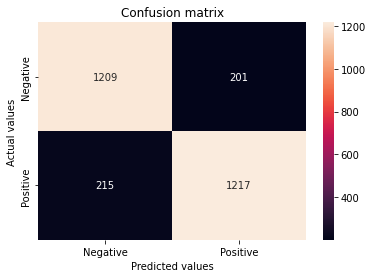

In [23]:
prediction = lstm_model_50n.predict(padded_test_cmts)
inverted = np.argmax(prediction, axis=1)
Model.confusionMatrix(y_test, inverted)

In [24]:
lstm_model_50n_uw = DeepModel.defineLSTM(vocab_size, embedding_dim, neurons, dropout)
lstm_model_50n_uw.load_weights("./models/LSTM_sentiment_50n_20e/weights/03-0.327739.h5")

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      1410
    Positive       0.88      0.86      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.87      0.87      0.87      2842
weighted avg       0.87      0.87      0.87      2842



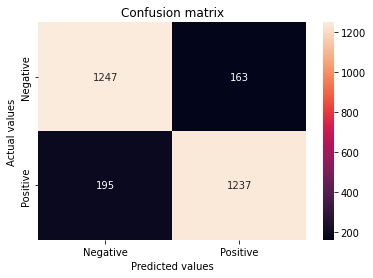

In [25]:
prediction = lstm_model_50n_uw.predict(padded_test_cmts)
inverted = np.argmax(prediction, axis=1)
Model.confusionMatrix(y_test, inverted)

> **Nhận xét**:
> * Dù với model 100 neuron thì kết quả đem lại vẫn không khả quan, điều này xảy ra có thể bởi vì dữ liệu của chúng ta không thật sự tốt, nhớ lại project 1, ta cho các review có 4 hoặc 5 sao là positive và từ 3 sao trở xuống là negative. Vậy câu hỏi đặt ra là ta phân lớp như vậy liệu có đúng.
> * Không loại trừ khả năng các khách hàng 3 sao là họ thuộc nhóm khách hàng bình thường, tức họ không thích cũng không ghét sản phẩm nhưng do dữ liệu của positive chiếm đa số mà ta đã vô tình ép họ vào nhóm negative.
> * Một điều nữa, có thể ta chưa khử noise tốt, nhiều comment mặc dù nhìn mặt chữ là khen nhưng đánh giá lại thấp sao và ngược lại. Điều này rất khó để kiểm soát vì với nhân lực của nhóm chỉ có 2 người và về tính khả quan ta không thể nào có thể sàn lọc kĩ càng các comment thuộc dạng này, hơn nữa nếu sài yếu tố con người thì ta đang vô tình tác động tính chất chủ quan của con người vào quá trình đào tạo model.

Chúng ta hoàn toàn có thể tối ưu hóa cho các HYper Parameter, nhưng nhìn chung rất có thể lỗi hiện tại của chúng ta là **variance error**, tức lỗi từ dữ liệu chứ không phải **bias error**.

Điều nữa là việc tối ưu hóa tham số cho một Deep Neural Network là rất tốn công sức, nhưng nhóm vẫn muốn trình bày một kĩ thuật là HyperBand, đây là bài báo của tác giả [https://arxiv.org/pdf/1603.06560.pdf](https://arxiv.org/pdf/1603.06560.pdf). Ý tưởng chính của phương pháp này là với $n$ HyperParameters set ban đầu được lấy từ GridSearch gồm $m$ hyperparameters set ($n < m$) do ta định nghĩa. Ta sẽ tiến hành train và đánh giá bằng một vài phép toán, qua các lần đào tạo trên từng model, ta chọn ra các model có hiệu suất tốt nhất và loại bỏ các model có performance thấp hơn (nhờ các phép toán thống kê và xác suất). Tiếp theo, người ta tiến hành cải thiện weight trên các model còn sót lại. Cứ như thế số model còn tồn tại sau cùng của quá trình là các model tốt nhất. Tuy nhiên nếu data của ta không tốt thì khi áp dụng phương pháp này sẽ gây ra overfitting.

Đây là một model phân lớp dữ liệu MNIST có sử dụng phương pháp hyperband này để tối ưu hóa tham số, và với một tập dữ liệu đẹp như MNIST thì phương pháp này cực kì ổn. [https://github.com/PacktPublishing/Deep-Learning-Quick-Reference/tree/master/Chapter06](https://github.com/PacktPublishing/Deep-Learning-Quick-Reference/tree/master/Chapter06)

In [33]:
lstm_model_final = DeepModel.SentimentLSTM(lstm_model_uw, tokenizer)

In [37]:
tmp = lstm_model_final.predict(X_test_comments)

In [38]:
tmp

,input,output_proba,output_class
0,bán hàng kỉ quấn đầy đủ chất lượng ok đồ chuẩn...,"(0.0009966072, 0.99900347)",1
1,đặt xl áo ghi xl nhưng bé tí tẹo ngang size mì...,"(0.99316263, 0.0068374383)",0
2,kẹp rất rất đẹp săn được giá sale hôm chỉ giá ...,"(0.5307486, 0.46925136)",0
3,không nghĩ áo đẹp giao hàng nhanh không bình t...,"(0.02204431, 0.97795576)",1
4,hôm nay mới nhận được nhưng nhìn qua thấy cũng...,"(0.8622492, 0.1377508)",0
...,...,...,...
2837,đặt dây buộc tóc nhưng chỉ nhận được cái nhắn ...,"(0.9942146, 0.0057854448)",0
2838,chất vải đẹp có vẻ mát giao hàng nhanh chóng đ...,"(0.028606944, 0.971393)",1
2839,dây nhìn tạm không đẹp mắc sai dây phải ngồi c...,"(0.99471915, 0.005280828)",0
2840,quần đẹp chất lượng ok nhưng chữ của quần màu ...,"(0.6221042, 0.37789577)",0


In [43]:
Model.saveByPickle(tokenizer, "./models/lstm_model_tokenizer.pickle")

<keras_preprocessing.text.Tokenizer object at 0x7fef2ca08df0> has been saved at ./models/lstm_model_tokenizer.pickle.


In [45]:
lstm_model_uw.save("./models/lstm_model_comments.h5")